# <span style="color:blue">NYC Real Estate</span>

This project seeks to generate a predictive model to estimate the price of New York City residential real estate properties based on criteria such as the borough, geographic location, construction date, number of units and square footage. 
Data Source: https://www.kaggle.com/new-york-city/nyc-property-sales

# Imports

In [1]:
#First import the necessary libraries and dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None
import statsmodels.api as sm
import numpy as np
pd.read_csv('nyc-rolling-sales.csv')


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,...,2,0,2,2400,2575,1998,1,B9,450000,2016-11-28 00:00:00
84544,8410,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,...,2,0,2,2498,2377,1998,1,B9,550000,2017-04-21 00:00:00
84545,8411,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,...,2,0,2,4000,1496,1925,1,B2,460000,2017-07-05 00:00:00
84546,8412,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,...,0,7,7,208033,64117,2001,4,K6,11693337,2016-12-21 00:00:00


# Data Cleansing

In [2]:
#Create dataframe
nyc = pd.read_csv('nyc-rolling-sales.csv')
#Replace borough names according to data source
nyc['BOROUGH'][nyc['BOROUGH'] == 1] = 'Manhattan'
nyc['BOROUGH'][nyc['BOROUGH'] == 2] = 'Bronx'
nyc['BOROUGH'][nyc['BOROUGH'] == 3] = 'Brooklyn'
nyc['BOROUGH'][nyc['BOROUGH'] == 4] = 'Queens'
nyc['BOROUGH'][nyc['BOROUGH'] == 5] = 'Staten Island'

In [3]:
#Check datatypes
print(nyc.dtypes)

Unnamed: 0                         int64
BOROUGH                           object
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object


In [4]:
#Drop extraneous columns:
#Unnamed is a meaningless column.
nyc.drop('Unnamed: 0', inplace=True, axis=1)
#Easement is an entirely blank column.
nyc.drop('EASE-MENT', inplace=True, axis=1)
#Remove location information that is too specific for this model:
#Neighborhood has 254 categories, which is too many to be used for this model. 
#Address and Apartment Number are far too specific to each datapoint to be useful.
#Block and Lot are likewise very specific NYC database information that will not be useful for this model.
#Instead I will use an area category generated from geographical info associated with the zip codes.
nyc.drop('NEIGHBORHOOD', inplace=True, axis=1)
nyc.drop('ADDRESS', inplace=True, axis=1)
nyc.drop('APARTMENT NUMBER', inplace=True, axis=1)
nyc.drop('BLOCK', inplace=True, axis=1)
nyc.drop('LOT', inplace=True, axis=1)
#Remove Building and Tax Class categories:
#Building Class Category includes 47 categories, which is too many to consider for this model.
#Building Class at Present and Building Class at Time of Sale includes 166 categories, also too many for this model.
#Tax Class at Present is removed because it is not as relevant to the sale price as Tax Class at Time of Sale.
#Tax Class at Time of Sale (4 categories) will be used to eliminate non-residential tax classes. 
nyc.drop('BUILDING CLASS CATEGORY', inplace=True, axis=1)
nyc.drop('BUILDING CLASS AT PRESENT', inplace=True, axis=1)
nyc.drop('BUILDING CLASS AT TIME OF SALE', inplace=True, axis=1)
nyc.drop('TAX CLASS AT PRESENT', inplace=True, axis=1)
#This model is concerned with residential real estate sales, so Commercial Units and Total Units are not needed.
nyc.drop('COMMERCIAL UNITS', inplace=True, axis=1)
nyc.drop('TOTAL UNITS', inplace=True, axis=1)
#Land square feet is not relevant to all residential sales, so it is removed.
nyc.drop('LAND SQUARE FEET', inplace=True, axis=1)

In [5]:
#Check datatypes
print(nyc.dtypes)

BOROUGH                      object
ZIP CODE                      int64
RESIDENTIAL UNITS             int64
GROSS SQUARE FEET            object
YEAR BUILT                    int64
TAX CLASS AT TIME OF SALE     int64
SALE PRICE                   object
SALE DATE                    object
dtype: object


In [6]:
#Correct datatypes
nyc['GROSS SQUARE FEET']= pd.to_numeric(nyc['GROSS SQUARE FEET'], errors='coerce')
nyc['SALE PRICE']= pd.to_numeric(nyc['SALE PRICE'], errors='coerce')
nyc['SALE DATE']= pd.to_datetime(nyc['SALE DATE'], errors='coerce')

In [7]:
#Check number of rows before removing 0 and nil values
print("There are " + str(len(nyc)) + " rows before removing 0 and nil values.")

There are 84548 rows before removing 0 and nil values.


In [8]:
#Remove rows with 0 values - rows with 0 in any remaining columns will not be relevant to model
nyc = nyc[(nyc != 0).all(1)]
#Check number of rows
print("There are " + str(len(nyc)) + " rows after removing 0 values.")

There are 45467 rows after removing 0 values.


In [9]:
#Remove rows with nil values - rows with nil in any remaining columns will not be relevant to model
nyc = nyc.dropna()
#Check number of rows
print("There are " + str(len(nyc)) + " rows after removing 0 and nil values.")

There are 28032 rows after removing 0 and nil values.


The high number of invalid rows in the dataset is concerning because only 33% of the dataset has non-zero values in the remaining columns and is therefore useable.

In [10]:
#Remove tax classes 3 and 4 since these apply to non-residential properties.
nyc.rename(columns = {'TAX CLASS AT TIME OF SALE':'TAXCLASSATTIMEOFSALE'}, inplace = True) 
nyc = nyc[nyc.TAXCLASSATTIMEOFSALE != 4]
nyc = nyc[nyc.TAXCLASSATTIMEOFSALE != 3]
print("There are " + str(len(nyc)) + " rows after excluding tax classes 3 and 4.")
#After this, Tax class will not be further used in the analysis so it is dropped.
nyc.drop('TAXCLASSATTIMEOFSALE', inplace=True, axis=1)

There are 27840 rows after excluding tax classes 3 and 4.


In [11]:
#Check datatypes
print(nyc.dtypes)

BOROUGH                      object
ZIP CODE                      int64
RESIDENTIAL UNITS             int64
GROSS SQUARE FEET           float64
YEAR BUILT                    int64
SALE PRICE                  float64
SALE DATE            datetime64[ns]
dtype: object


In [12]:
#Update float columns to integer
nyc['GROSS SQUARE FEET'] = nyc['GROSS SQUARE FEET'].astype(int)
nyc['SALE PRICE'] = nyc['SALE PRICE'].astype(int)
#Sort by sale price and reindex.
nyc = nyc.sort_values('SALE PRICE')
nyc = nyc.reset_index(drop=True)
#Print dataset stats
print(nyc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27840 entries, 0 to 27839
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   BOROUGH            27840 non-null  object        
 1   ZIP CODE           27840 non-null  int64         
 2   RESIDENTIAL UNITS  27840 non-null  int64         
 3   GROSS SQUARE FEET  27840 non-null  int64         
 4   YEAR BUILT         27840 non-null  int64         
 5   SALE PRICE         27840 non-null  int64         
 6   SALE DATE          27840 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 1.5+ MB
None


<b>Converting Year Built to Building Age</b>
Building age will be a more useful metric for the model, so I'll convert year built using 2017, the year when the majority of sales in the dataset occurred, then drop year built. 

In [13]:
nyc['BUILDING AGE'] = 2017 - nyc['YEAR BUILT']
nyc.drop('YEAR BUILT', inplace=True, axis=1)

<b>Adding Area Category</b>
In order to analyze the data by geographic area, I will use the zip codes to designate geographic areas that are assigned by NE, NW, SE and SW for each NYC borough. This requires importing a separate file I have created with zip codes and geographic areas. This file was created by analyzing longitude and latitude data for zip codes from https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/

In [14]:
pd.read_csv('nyczipcodes.csv')

,ZIP CODE,AREA
0,10453,BRONX NW
1,10457,BRONX SW
2,10460,BRONX SW
3,10458,BRONX NW
4,10467,BRONX NE
...,...,...
178,11249,BROOKLYN NW
179,11001,QUEENS NE
180,11040,QUEENS NE
181,10803,BRONX NE


In [15]:
zip = pd.read_csv('nyczipcodes.csv')
nyc = nyc.merge(zip, how='left', on='ZIP CODE')
nyc.set_index
nyc.index.name = 'Index'
print(nyc)
print(nyc.info())

             BOROUGH  ZIP CODE  RESIDENTIAL UNITS  GROSS SQUARE FEET  \
Index                                                                  
0              Bronx     10459                 71              75672   
1      Staten Island     10312                  2               1165   
2      Staten Island     10303                  1                828   
3           Brooklyn     11210                  1               1624   
4             Queens     11412                  1               1356   
...              ...       ...                ...                ...   
27835       Brooklyn     11201                  8               5802   
27836      Manhattan     10024                153             141498   
27837      Manhattan     10005                317             303175   
27838      Manhattan     10005                476             400531   
27839      Manhattan     10016                894             829024   

       SALE PRICE  SALE DATE  BUILDING AGE              AREA  


Next I'll add one-hot encoding for the borough and area columns to prepare the dataset for linear regression.

In [16]:
borough = pd.get_dummies(nyc.BOROUGH, prefix='Borough')
borough.set_index
borough.index.name = 'Index'
area = pd.get_dummies(nyc.AREA, prefix='Area')
area.set_index
area.index.name = 'Index'
print(borough.index.name)
nyc = nyc.merge(borough, on = 'Index')
nyc = nyc.merge(area, on = 'Index')
print(nyc)

Index
             BOROUGH  ZIP CODE  RESIDENTIAL UNITS  GROSS SQUARE FEET  \
Index                                                                  
0              Bronx     10459                 71              75672   
1      Staten Island     10312                  2               1165   
2      Staten Island     10303                  1                828   
3           Brooklyn     11210                  1               1624   
4             Queens     11412                  1               1356   
...              ...       ...                ...                ...   
27835       Brooklyn     11201                  8               5802   
27836      Manhattan     10024                153             141498   
27837      Manhattan     10005                317             303175   
27838      Manhattan     10005                476             400531   
27839      Manhattan     10016                894             829024   

       SALE PRICE  SALE DATE  BUILDING AGE              A

In [17]:
#Show info for cleaned dataset.
nyc.to_csv(r'/Users/Nicholas/nyc-rolling-sales-updated.csv')
print(nyc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27840 entries, 0 to 27839
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   BOROUGH                27840 non-null  object        
 1   ZIP CODE               27840 non-null  int64         
 2   RESIDENTIAL UNITS      27840 non-null  int64         
 3   GROSS SQUARE FEET      27840 non-null  int64         
 4   SALE PRICE             27840 non-null  int64         
 5   SALE DATE              27840 non-null  datetime64[ns]
 6   BUILDING AGE           27840 non-null  int64         
 7   AREA                   27840 non-null  object        
 8   Borough_Bronx          27840 non-null  uint8         
 9   Borough_Brooklyn       27840 non-null  uint8         
 10  Borough_Manhattan      27840 non-null  uint8         
 11  Borough_Queens         27840 non-null  uint8         
 12  Borough_Staten Island  27840 non-null  uint8         
 13  A

I will refine the dataset a bit more in the data exploration phase.

# Exploratory Data Analysis

<b>Sale Price</b> First I'll analyze the sale price data, which is what the model will predit. I'll determine the range of data to include in the model.

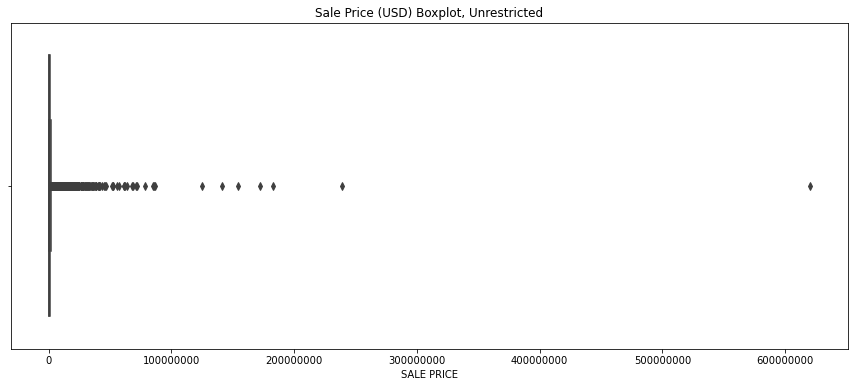

In [18]:
## Generate boxplot for sale price
plt.figure(figsize=(15,6))
sns.boxplot(x='SALE PRICE', data=nyc)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Sale Price (USD) Boxplot, Unrestricted')
plt.show()

From the chart above it is clear that there is a concentration of values at the low end 
and outliers at the higher end. The lowest sale prices may represent gifts rather than valid sales, and the highest sale prices are too spread out to be useful to the model. Let's see how the dataset changes when I restrict the sale price range to 100,000 - 10,000,000. 100,000 is a resonable lower end for NYC real estate, and over $10M would represent high-end properties. This includes approximately 94% of the remaining dataset.

There are 26220 rows after restricting the sale price range from $100,0000 to $10M.


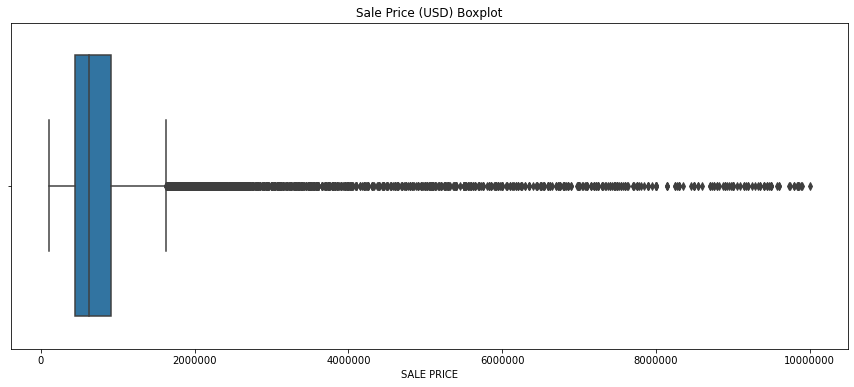

In [19]:
#Restrict range, count remaining rows and generate boxplot
nyc = nyc[(nyc['SALE PRICE'] > 100000) & (nyc['SALE PRICE'] < 10000000)]
print("There are " + str(len(nyc)) + " rows after restricting the sale price range from $100,0000 to $10M.")
plt.figure(figsize=(15,6))
sns.boxplot(x='SALE PRICE', data=nyc)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Sale Price (USD) Boxplot')
plt.show()

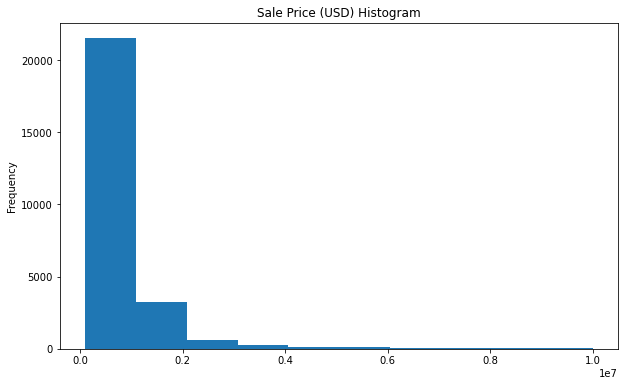

In [20]:
#Create histogram for sales price
plt.figure(figsize=(10,6))
plt.hist(nyc['SALE PRICE'])
plt.title('Sale Price (USD) Histogram')
plt.ylabel('Frequency')
plt.show()

<b>Borough and Area</b> Below are plots of the distribution of sale price by borough and geographic area.

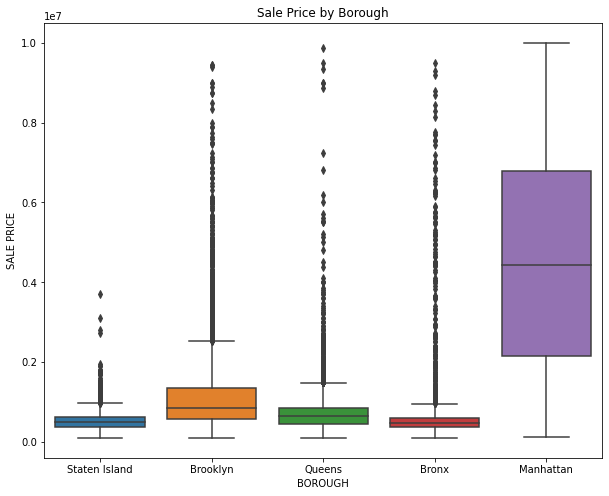

In [21]:
plt.figure(figsize=(10,8))
sns.boxplot(x='BOROUGH', y='SALE PRICE', data=nyc)
plt.title('Sale Price by Borough')
plt.show()

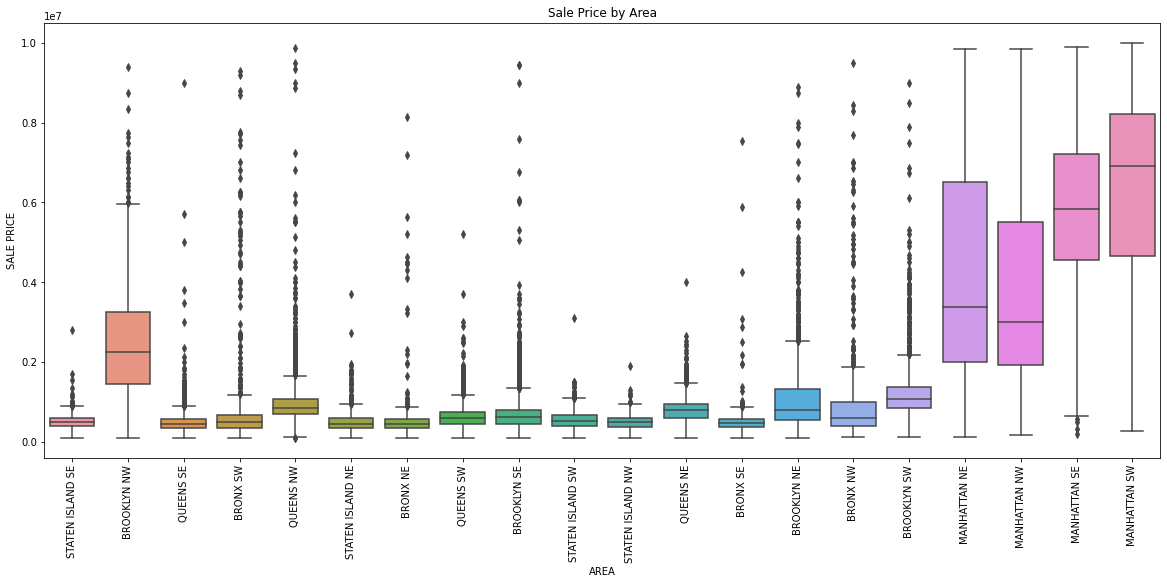

In [22]:
plt.figure(figsize=(20,8))
sns.boxplot(x='AREA', y='SALE PRICE', data=nyc)
plt.title('Sale Price by Area')
plt.xticks(rotation=90)
plt.show()

Next I'll check and update the ranges for Residential Units and Gross Square Feet.

<b>Residential Units</b>

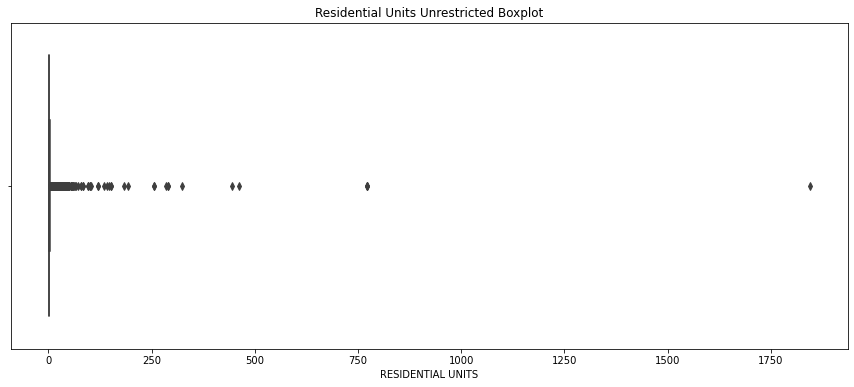

In [23]:
plt.figure(figsize=(15,6))
sns.boxplot(x='RESIDENTIAL UNITS', data=nyc)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Residential Units Unrestricted Boxplot')
plt.show()

I'll restrict the upper range for Residential Units to 100 to eliminate the highest outliers while retaining 99.9% of the remaining dataset.

There are 26196 rows after restricting the residential units range.


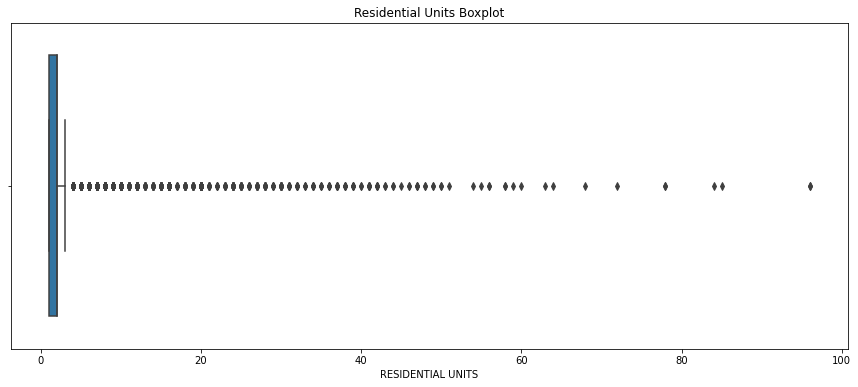

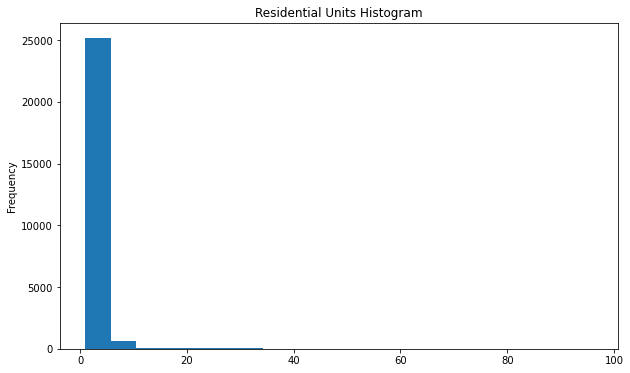

In [24]:
#Restrict Residential Units range, count remaining rows and generate boxplot and histrogram
nyc = nyc[(nyc['RESIDENTIAL UNITS'] < 100)]
print("There are " + str(len(nyc)) + " rows after restricting the residential units range.")
plt.figure(figsize=(15,6))
sns.boxplot(x='RESIDENTIAL UNITS', data=nyc)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Residential Units Boxplot')
plt.show()
plt.figure(figsize=(10,6))
plt.hist(nyc['RESIDENTIAL UNITS'], bins = 20)
plt.title('Residential Units Histogram')
plt.ylabel('Frequency')
plt.show()

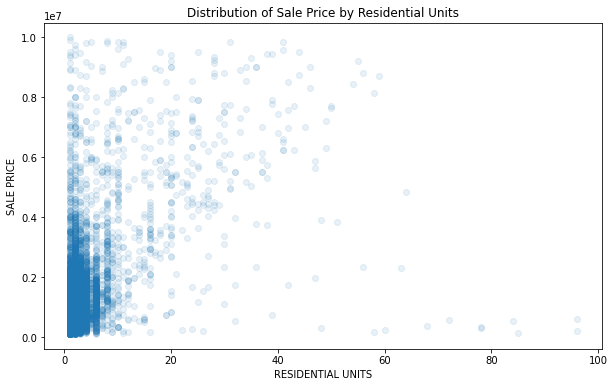

In [25]:
plt.figure(figsize=(10,6))
sns.regplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=nyc, fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('Distribution of Sale Price by Residential Units')
plt.show()

<b>Gross Square Feet</b>

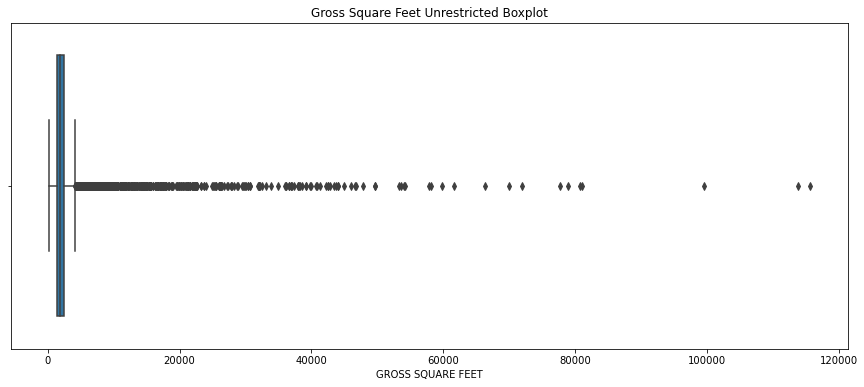

In [26]:
plt.figure(figsize=(15,6))
sns.boxplot(x='GROSS SQUARE FEET', data=nyc)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Gross Square Feet Unrestricted Boxplot')
plt.show()

I'll restrict the upper range for Gross Square Feet to 50,000 to remove the highest outliers while retaining 99.9% of the remaining dataset.

There are 26178 rows after restricting the gross square feet range.


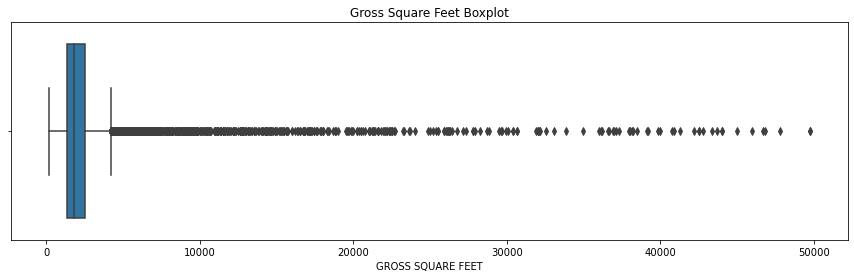

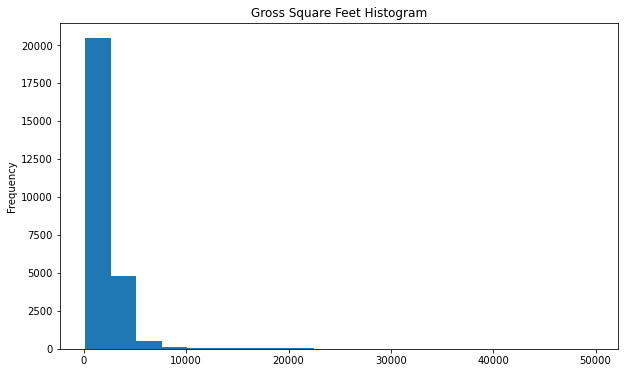

In [27]:
#Restrict Gross Square Feet range, count remaining rows and generate boxplot and histrogram
nyc = nyc[(nyc['GROSS SQUARE FEET'] < 50000)]
print("There are " + str(len(nyc)) + " rows after restricting the gross square feet range.")
plt.figure(figsize=(15,4))
sns.boxplot(x='GROSS SQUARE FEET', data=nyc)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Gross Square Feet Boxplot')
plt.show()
plt.figure(figsize=(10,6))
plt.hist(nyc['GROSS SQUARE FEET'], bins = 20)
plt.title('Gross Square Feet Histogram')
plt.ylabel('Frequency')
plt.show()

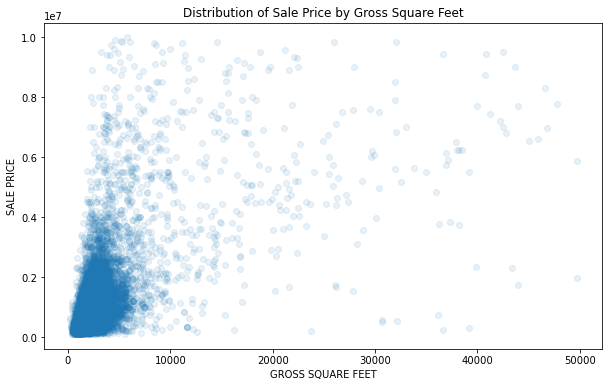

In [28]:
plt.figure(figsize=(10,6))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=nyc, fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('Distribution of Sale Price by Gross Square Feet')
plt.show()

<b>Building Age</b>

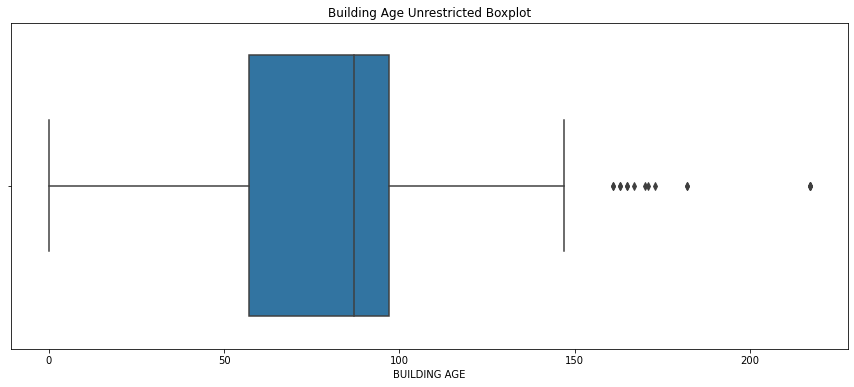

In [29]:
plt.figure(figsize=(15,6))
sns.boxplot(x='BUILDING AGE', data=nyc)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Building Age Unrestricted Boxplot')
plt.show()

The dataset will not be further restricted based on building age.

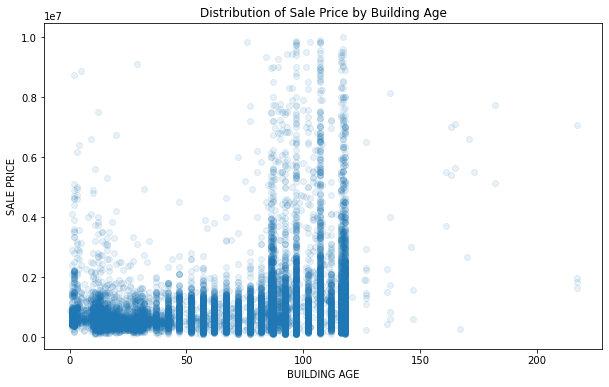

In [30]:
plt.figure(figsize=(10,6))
sns.regplot(x='BUILDING AGE', y='SALE PRICE', data=nyc, fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('Distribution of Sale Price by Building Age')
plt.show()

In [31]:
nyc.to_csv(r'/Users/Nicholas/nyc-rolling-sales-updated.csv')
#Show info for updated dataset.
print(nyc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26178 entries, 1298 to 27517
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   BOROUGH                26178 non-null  object        
 1   ZIP CODE               26178 non-null  int64         
 2   RESIDENTIAL UNITS      26178 non-null  int64         
 3   GROSS SQUARE FEET      26178 non-null  int64         
 4   SALE PRICE             26178 non-null  int64         
 5   SALE DATE              26178 non-null  datetime64[ns]
 6   BUILDING AGE           26178 non-null  int64         
 7   AREA                   26178 non-null  object        
 8   Borough_Bronx          26178 non-null  uint8         
 9   Borough_Brooklyn       26178 non-null  uint8         
 10  Borough_Manhattan      26178 non-null  uint8         
 11  Borough_Queens         26178 non-null  uint8         
 12  Borough_Staten Island  26178 non-null  uint8         
 13

<b>Creating Predictive Regression Models</b>

First I'll create a heatmap using all numerical categories except for Zip Code and Sale Date.

Text(0.5, 1.0, 'Heat Map')

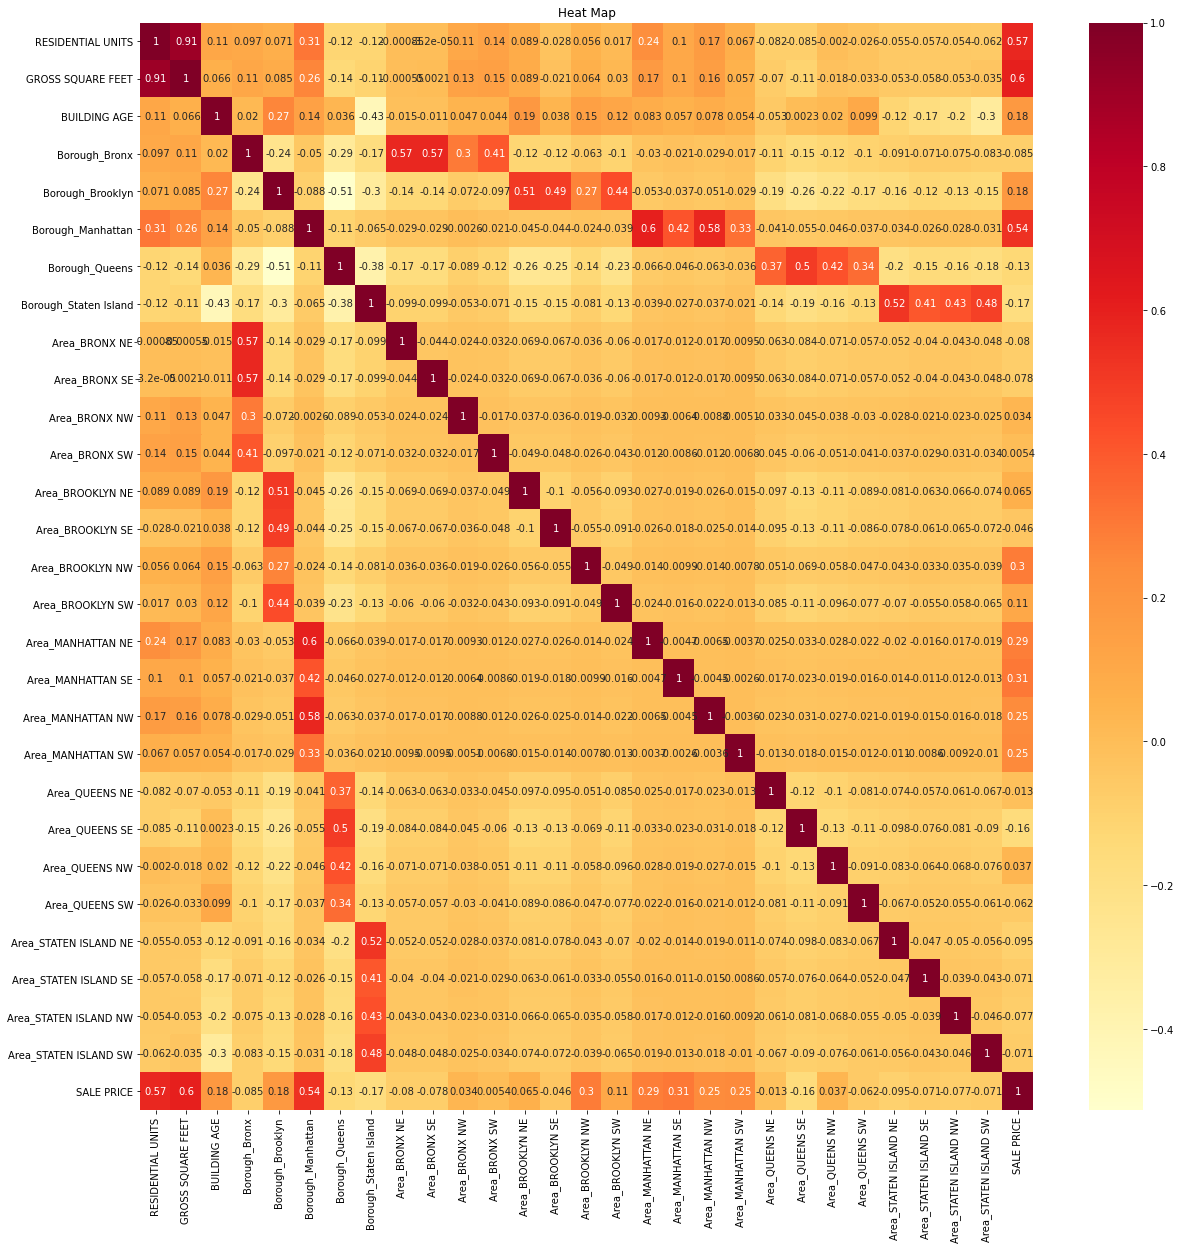

In [32]:
filt = ['RESIDENTIAL UNITS', 'GROSS SQUARE FEET', 'BUILDING AGE',
        'Borough_Bronx', 'Borough_Brooklyn', 'Borough_Manhattan', 'Borough_Queens', 'Borough_Staten Island', 
        'Area_BRONX NE', 'Area_BRONX SE', 'Area_BRONX NW', 'Area_BRONX SW',
        'Area_BROOKLYN NE', 'Area_BROOKLYN SE', 'Area_BROOKLYN NW', 'Area_BROOKLYN SW',
        'Area_MANHATTAN NE', 'Area_MANHATTAN SE', 'Area_MANHATTAN NW', 'Area_MANHATTAN SW',
        'Area_QUEENS NE', 'Area_QUEENS SE', 'Area_QUEENS NW', 'Area_QUEENS SW',
        'Area_STATEN ISLAND NE', 'Area_STATEN ISLAND SE', 'Area_STATEN ISLAND NW', 'Area_STATEN ISLAND SW',
        'SALE PRICE']

nyccorr = nyc[filt].corr()
plt.figure(figsize=(20,20))
nycheatmap = sns.heatmap(nyccorr, cmap='YlOrRd', annot=True)
plt.title("Heat Map")

Next I'll compare the correlations of all of the variables with Sale Price.

Text(0.5, 1.0, 'Correlated Features')

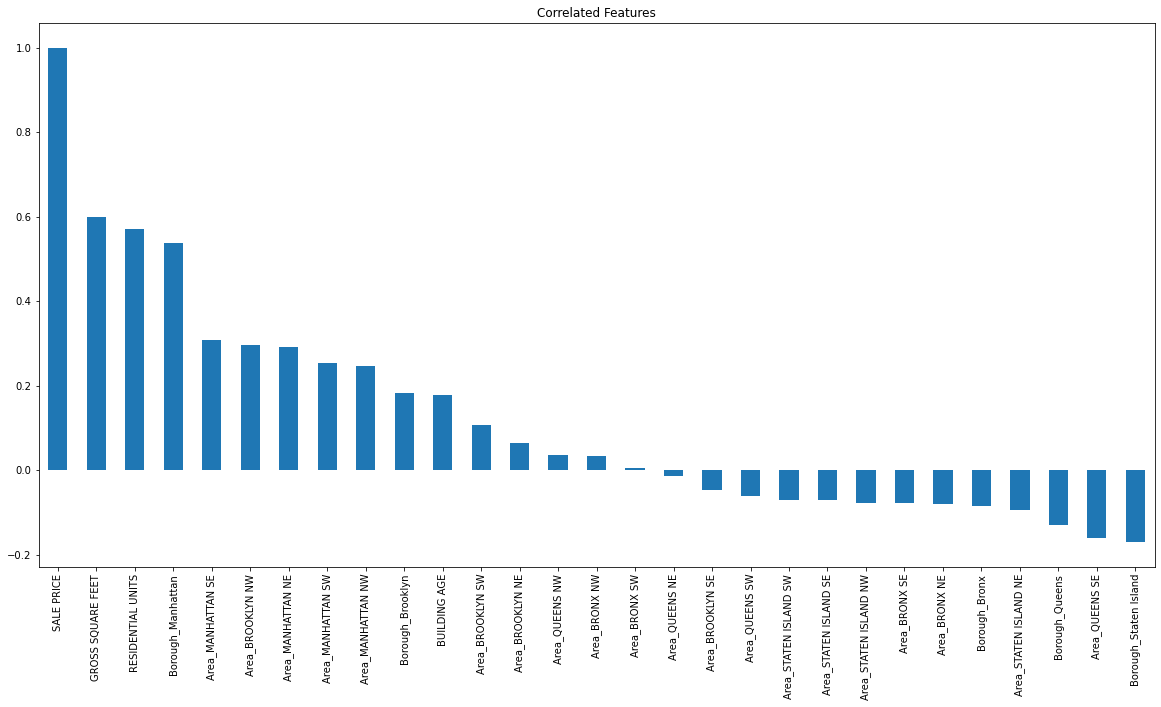

In [33]:
plt.figure(figsize=(20,10))
colList_corr = nyccorr.columns
nyccorr=nyccorr.sort_values('SALE PRICE', ascending=False)
nyccorr['SALE PRICE'].plot(kind='bar')
plt.xticks(rotation=90)
plt.title("Correlated Features")

From the chart above it is clear that Gross Square Feet and Residential Units are the most significant predictors of sale price, while the borough and areas data are less signifant, and Building Age has a low correlation. While it's interesting to see how the boroughs compare with the specific areas in correlating with sale price, it would be double counting to include both boroughs and areas in the model. So the regression model will include the specific areas data and exclude the boroughs data.

<b>Regression Model 1: Predicting Sale Price from Residential Units, Gross Square Feet, Building Age and Geographical Areas</b>

In [34]:
filt2 = ['RESIDENTIAL UNITS', 'GROSS SQUARE FEET', 'BUILDING AGE',
        'Area_BRONX NE', 'Area_BRONX SE', 'Area_BRONX NW', 'Area_BRONX SW',
        'Area_BROOKLYN NE', 'Area_BROOKLYN SE', 'Area_BROOKLYN NW', 'Area_BROOKLYN SW',
        'Area_MANHATTAN NE', 'Area_MANHATTAN SE', 'Area_MANHATTAN NW', 'Area_MANHATTAN SW',
        'Area_QUEENS NE', 'Area_QUEENS SE', 'Area_QUEENS NW', 'Area_QUEENS SW',
        'Area_STATEN ISLAND NE', 'Area_STATEN ISLAND SE', 'Area_STATEN ISLAND NW', 'Area_STATEN ISLAND SW']
X = nyc[filt2]
y = nyc['SALE PRICE']

OLSmodel = sm.OLS(y, X)
OLSmodelResult = OLSmodel.fit()
OLSmodelResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE PRICE   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     2269.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:15:42   Log-Likelihood:            -3.8331e+05
No. Observations:               26178   AIC:                         7.667e+05
Df Residuals:                   26155   BIC:                         7.669e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
RESIDENTIAL UNITS       313.4958   2827.827      0.111      0.912   -5229.199    5856.191
GROSS SQUARE FEET       178.5349      3.361     53.122      0.000     171.947     185.122
BUILDING AGE            253.6491    131.863      1.924      0.054      -4.810     512.108
Area_BRONX NE          7.569e+04   1.97e+04      3.836      0.000     3.7e+04    1.14e+05
Area_BRONX SE           8.05e+04   1.98e+04      4.071      0.000    4.17e+04    1.19e+05
Area_BRONX NW          1.898e+05   3.41e+04      5.572      0.000    1.23e+05    2.57e+05
Area_BRONX SW          3.564e+04   2.67e+04      1.334      0.182   -1.67e+04     8.8e+04
Area_BROOKLYN NE       4.981e+05   1.74e+04     28.660      0.000    4.64e+05    5.32e+05
Area_BROOKLYN SE       3.278e+05    1.6e+04     20.485      0.000    2.96e+05    3.59e+05
Area_BROOKLYN NW       1.883e+06   2.49e+04     75.570      0.000    1.83e+06    1.93e+06
Area_BROOKLYN SW       7.373e+05   1.78e+04     41.513      0.000    7.02e+05    7.72e+05
Area_MANHATTAN NE      2.818e+06   4.59e+04     61.349      0.000    2.73e+06    2.91e+06
Area_MANHATTAN SE      4.703e+06   6.22e+04     75.566      0.000    4.58e+06    4.83e+06
Area_MANHATTAN NW      2.506e+06   4.71e+04     53.170      0.000    2.41e+06     2.6e+06
Area_MANHATTAN SW      5.198e+06    7.8e+04     66.669      0.000    5.05e+06    5.35e+06
Area_QUEENS NE         4.998e+05   1.57e+04     31.927      0.000    4.69e+05     5.3e+05
Area_QUEENS SE         1.728e+05   1.41e+04     12.295      0.000    1.45e+05       2e+05
Area_QUEENS NW         5.617e+05   1.54e+04     36.496      0.000    5.32e+05    5.92e+05
Area_QUEENS SW         2.705e+05   1.78e+04     15.159      0.000    2.35e+05    3.05e+05
Area_STATEN ISLAND NE  1.723e+05   1.68e+04     10.280      0.000    1.39e+05    2.05e+05
Area_STATEN ISLAND SE   2.24e+05   1.95e+04     11.482      0.000    1.86e+05    2.62e+05
Area_STATEN ISLAND NW   1.99e+05   1.85e+04     10.748      0.000    1.63e+05    2.35e+05
Area_STATEN ISLAND SW  2.195e+05   1.67e+04     13.167      0.000    1.87e+05    2.52e+05
==============================================================================
Omnibus:                    10219.802   Durbin-Watson:                   1.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1820577.922
Skew:                           0.765   Prob(JB):                         0.00
Kurtosis:                      43.826   Cond. No.                     7.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Since Residential Units and Gross Square Feet are the most significant independent variables, I'll create a second regression to test the model using only these two variables.

<b>Regression Model 2: Predicting Sale Price from Residential Units and Gross Square Feet</b>

In [35]:
filt3 = ['RESIDENTIAL UNITS', 'GROSS SQUARE FEET']
X2 = nyc[filt3]
y = nyc['SALE PRICE']

OLSmodel2 = sm.OLS(y, X2)
OLSmodelResult2 = OLSmodel2.fit()
OLSmodelResult2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             SALE PRICE   R-squared (uncentered):                   0.613
Model:                            OLS   Adj. R-squared (uncentered):              0.613
Method:                 Least Squares   F-statistic:                          2.069e+04
Date:                Sun, 25 Oct 2020   Prob (F-statistic):                        0.00
Time:                        17:15:42   Log-Likelihood:                     -3.9282e+05
No. Observations:               26178   AIC:                                  7.856e+05
Df Residuals:                   26176   BIC:                                  7.857e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
RESIDENTIAL UNITS  5481.1041   3837.974      1.428      0.153   -2041.535     1.3e+04
GROSS SQUARE FEET   291.9765      4.144     70.451      0.000     283.853     300.100
==============================================================================
Omnibus:                    13808.082   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1916107.060
Skew:                           1.525   Prob(JB):                         0.00
Kurtosis:                      44.802   Cond. No.                     2.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Key Insights

<b>Regression Model Including All Variables</b> The plot below shows the actual sales price values and the predicted values using the model with all variables.

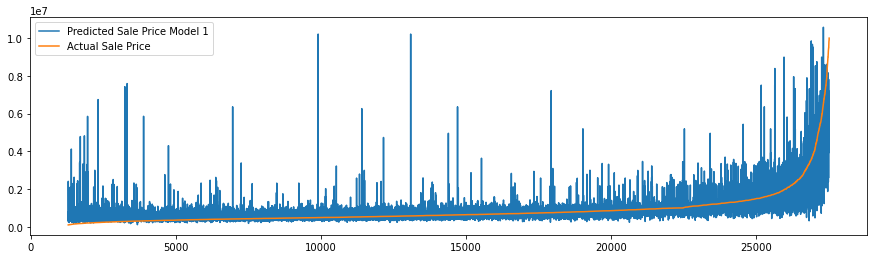

In [36]:
mpl.rcParams['figure.figsize'] = (15,4)

yPrediction = OLSmodelResult.predict(X)
plt.plot(yPrediction, label='Predicted Sale Price Model 1')
plt.plot(y, label='Actual Sale Price')
#legend, title, axis titles
plt.legend()
#ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

<b>Regression Model Including Two Variables</b> The plot below shows the actual sales price values and the predicted values using the model with only the two most significant variables, Residential Units and Gross Square Feet.

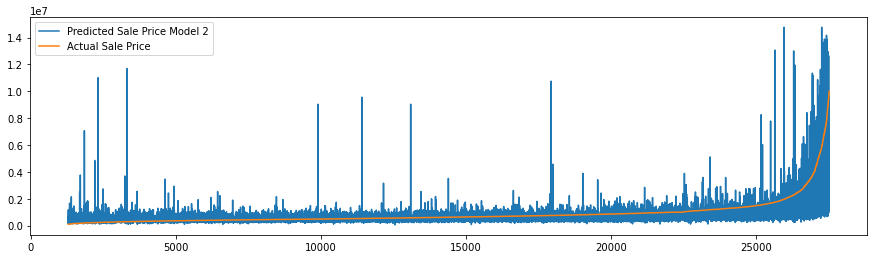

In [37]:
mpl.rcParams['figure.figsize'] = (15,4)

yPrediction = OLSmodelResult2.predict(X2)
plt.plot(yPrediction, label='Predicted Sale Price Model 2')
plt.plot(y, label='Actual Sale Price')
#legend, title, axis titles
plt.legend()
#ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

<p><b>Insights:</b></p> 
<p>-The first regression model has an r squared value of about 66%, which indicates that 66% of the variance for Sale Price is explained by the independent variables of Residential Units, Gross Square Feet, Building Age and Geographical Areas. The second regression model has an r squared value of 61%, indicating that Residential Units and Gross Square Feet alone predict 61% of the variance and the impact of the other variables in model 1 is negligible.</p> 
<p>-This dataset included a large proportion of rows that had to be disregarded due to 0 or null values in key categories, so that only about 33% of the data was useable.</P> 
<P>-The dataset was limited to a 2016-2017 time period and did not consider economic data that would impact sales price over a longer time period. Also, the dataset did not provide information that could have been useful for a pricing model, such as whether or not the building has been refurbished, and if building amenities such as a doorman, elevator, parking, gym, outdoor space, etc. are present that play a role in sales prices.</p>
<p>-Perhaps a more complete dataset with additional information would yield a stronger regression model to predict sales prices of NYC residential real estate using this analysis.</p>